# 프로젝트: Face2Emoji 모바일 웹앱 만들기

## Step 1. 표정 데이터로 MobileNet 학습하기

### Data 다운받기:  
https://www.kaggle.com/ahmedmoorsy/facial-expression

### train, validation 데이터셋 구경하기

얼굴 흑백 픽셀값 pixels 칼럼을 X 항목으로, 감정 번호 emotion 칼럼을 y 항목으로 삼으려합니다.  
X 항목은 48x48 픽셀의 grayscale images 입니다. 이것을 (48,48,1)로 reshape하고 255로 나누어 정규화해주겠습니다. 

In [1]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:24<00:00, 1478.56it/s]

train : 32298, eval :3589


Angry


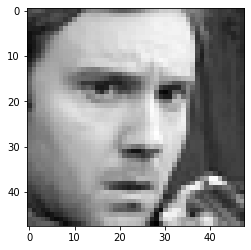

In [2]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

### MobileNet 모델 학습하기

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [5]:
EPOCHS=150
BATCH_SIZE=256

콜백함수 참조: 
https://teddylee777.github.io/tensorflow/keras-%EC%BD%9C%EB%B0%B1%ED%95%A8%EC%88%98-vol-03

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCHS, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# 콜백 정의
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

In [8]:
history=model.fit(np.stack(train_x),
                  tf.keras.utils.to_categorical(train_y),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(np.stack(eval_x), tf.keras.utils.to_categorical(eval_y)),
                  callbacks=[checkpoint, reduceLR]
                  )

Epoch 1/150
127/127 [==============================] - ETA: 0s - loss: 1.7851 - categorical_accuracy: 0.2741
Epoch 00001: val_loss improved from inf to 1.91124, saving model to checkpoint-epoch-150-batch-256-trial-001.h5
127/127 [==============================] - 9s 68ms/step - loss: 1.7851 - categorical_accuracy: 0.2741 - val_loss: 1.9112 - val_categorical_accuracy: 0.2449 - lr: 0.0010
Epoch 2/150
126/127 [============================>.] - ETA: 0s - loss: 1.6115 - categorical_accuracy: 0.3675
Epoch 00002: val_loss improved from 1.91124 to 1.89118, saving model to checkpoint-epoch-150-batch-256-trial-001.h5
127/127 [==============================] - 7s 58ms/step - loss: 1.6113 - categorical_accuracy: 0.3675 - val_loss: 1.8912 - val_categorical_accuracy: 0.2449 - lr: 0.0010
Epoch 3/150
126/127 [============================>.] - ETA: 0s - loss: 1.5077 - categorical_accuracy: 0.4146
Epoch 00003: val_loss improved from 1.89118 to 1.89048, saving model to checkpoint-epoch-150-batch-256-tria

126/127 [============================>.] - ETA: 0s - loss: 0.1489 - categorical_accuracy: 0.9484
Epoch 00024: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 55ms/step - loss: 0.1489 - categorical_accuracy: 0.9483 - val_loss: 2.0246 - val_categorical_accuracy: 0.1655 - lr: 5.0000e-04
Epoch 25/150
126/127 [============================>.] - ETA: 0s - loss: 0.1395 - categorical_accuracy: 0.9523
Epoch 00025: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.1396 - categorical_accuracy: 0.9523 - val_loss: 2.0446 - val_categorical_accuracy: 0.1655 - lr: 5.0000e-04
Epoch 26/150
126/127 [============================>.] - ETA: 0s - loss: 0.1441 - categorical_accuracy: 0.9491
Epoch 00026: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.1448 - categorical_accuracy: 0.9488 - val_loss: 2.0901 - val_categorical_accuracy: 0.1655 - lr: 5.0000e-04
Epoch 27/15

Epoch 49/150
126/127 [============================>.] - ETA: 0s - loss: 0.0062 - categorical_accuracy: 0.9971
Epoch 00049: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.0063 - categorical_accuracy: 0.9971 - val_loss: 3.5656 - val_categorical_accuracy: 0.3834 - lr: 1.2500e-04
Epoch 50/150
126/127 [============================>.] - ETA: 0s - loss: 0.0061 - categorical_accuracy: 0.9971
Epoch 00050: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.0063 - categorical_accuracy: 0.9970 - val_loss: 3.6022 - val_categorical_accuracy: 0.3982 - lr: 1.2500e-04
Epoch 51/150
126/127 [============================>.] - ETA: 0s - loss: 0.0101 - categorical_accuracy: 0.9958
Epoch 00051: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0101 - categorical_accuracy: 0.9957 - val_loss: 3.5096 - val_categorical_accuracy: 0.4182 - lr: 1.2500e-0

Epoch 74/150
126/127 [============================>.] - ETA: 0s - loss: 0.0039 - categorical_accuracy: 0.9980
Epoch 00074: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.0039 - categorical_accuracy: 0.9980 - val_loss: 4.5332 - val_categorical_accuracy: 0.5079 - lr: 1.5625e-05
Epoch 75/150
126/127 [============================>.] - ETA: 0s - loss: 0.0042 - categorical_accuracy: 0.9978
Epoch 00075: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.0042 - categorical_accuracy: 0.9978 - val_loss: 4.5565 - val_categorical_accuracy: 0.5060 - lr: 1.5625e-05
Epoch 76/150
126/127 [============================>.] - ETA: 0s - loss: 0.0037 - categorical_accuracy: 0.9979
Epoch 00076: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 57ms/step - loss: 0.0038 - categorical_accuracy: 0.9979 - val_loss: 4.5827 - val_categorical_accuracy: 0.5060 - lr: 1.5625e-0

Epoch 99/150
126/127 [============================>.] - ETA: 0s - loss: 0.0034 - categorical_accuracy: 0.9980
Epoch 00099: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 57ms/step - loss: 0.0034 - categorical_accuracy: 0.9980 - val_loss: 4.7915 - val_categorical_accuracy: 0.5107 - lr: 3.9063e-06
Epoch 100/150
126/127 [============================>.] - ETA: 0s - loss: 0.0036 - categorical_accuracy: 0.9980
Epoch 00100: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 56ms/step - loss: 0.0037 - categorical_accuracy: 0.9980 - val_loss: 4.7965 - val_categorical_accuracy: 0.5110 - lr: 3.9063e-06
Epoch 101/150
127/127 [==============================] - ETA: 0s - loss: 0.0035 - categorical_accuracy: 0.9980
Epoch 00101: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 57ms/step - loss: 0.0035 - categorical_accuracy: 0.9980 - val_loss: 4.7969 - val_categorical_accuracy: 0.5116 - lr: 3.9063e

Epoch 124/150
126/127 [============================>.] - ETA: 0s - loss: 0.0032 - categorical_accuracy: 0.9983
Epoch 00124: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0033 - categorical_accuracy: 0.9982 - val_loss: 4.8213 - val_categorical_accuracy: 0.5107 - lr: 4.8828e-07
Epoch 125/150
126/127 [============================>.] - ETA: 0s - loss: 0.0034 - categorical_accuracy: 0.9983
Epoch 00125: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0034 - categorical_accuracy: 0.9983 - val_loss: 4.8218 - val_categorical_accuracy: 0.5113 - lr: 4.8828e-07
Epoch 126/150
126/127 [============================>.] - ETA: 0s - loss: 0.0037 - categorical_accuracy: 0.9981
Epoch 00126: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0037 - categorical_accuracy: 0.9980 - val_loss: 4.8226 - val_categorical_accuracy: 0.5110 - lr: 4.8828

Epoch 149/150
126/127 [============================>.] - ETA: 0s - loss: 0.0035 - categorical_accuracy: 0.9983
Epoch 00149: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0035 - categorical_accuracy: 0.9983 - val_loss: 4.8252 - val_categorical_accuracy: 0.5104 - lr: 1.2207e-07
Epoch 150/150
126/127 [============================>.] - ETA: 0s - loss: 0.0035 - categorical_accuracy: 0.9981
Epoch 00150: val_loss did not improve from 1.85830
127/127 [==============================] - 7s 54ms/step - loss: 0.0035 - categorical_accuracy: 0.9981 - val_loss: 4.8250 - val_categorical_accuracy: 0.5104 - lr: 1.2207e-07


## Step 2. 학습된 모델을 TensorFlow.js 형식으로 변환하기

In [9]:
import os
model_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/model.h5'
model.save(model_path)

cd ~/aiffel/tfjs_mobile/

!tensorflowjs_converter --input_format=keras model.h5 model

## Step 3. 카메라에서 가져온 영상 전처리하기

## Step 4. MobileNet 추론 결과 표시하기

## Step 5. github page에 HTML과 MobileNet 모델 배포하기

3,4,5 작업은 https://github.com/jpark9595/tfjs_mobile 에서 확인하실수 있습니다.

### 완성된url: https://jpark9595.github.io/tfjs_mobile/

# 결과 및 분석

자바스트립트를 사용하여 얼굴 감정인식의 결과를 이모지로 표현해주는 웹앱을 만들어 보았습니다.

MobileNetV2모델에서 학습이 잘 진행되지 않아 콜백함수를 추가로 사용하여 51%의 정확도를 이끌어 낼수 있었습니다.(더 높은 정확도를 이끌어 내기 위하여 다른 방법을 시도해 보아도 좋을것 같습니다.)